In [1]:
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
#user param
seqFileName = 'D:/RahLab/deepBreaks/genome/Genome.fasta'
metaDataFileName = 'D:/RahLab/deepBreaks/genome/metadataWithClusters.tsv'
mt = 'Organism'
seq_type = 'nu'
anaType = 'cl'
sampleFrac=1

In [4]:
# making directory
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
print('reading meta-data')
# metaData = pd.read_csv(args.metadata, sep='\t', index_col=0)
metaData = prp.read_data(metaDataFileName, seq_type = None, is_main=False)
print('metaData:', metaData.shape)

#importing seq data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading meta-data
metaData: (1340, 4)
reading fasta file
Done
Shape of data is:  (1340, 42484)


In [6]:
#taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
### add these steps to the powerpoint slide preproccess!
df_cleaned = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df_cleaned.shape)

Shape of data before missing/constant care:  (1340, 42484)
Shape of data after missing/constant care:  (1340, 22689)


In [7]:
print('Shape of data before imbalanced care: ', df_cleaned.shape)
df_cleaned = prp.imb_care(dat=df_cleaned, imbalance_threshold=0.025)
print('Shape of data after imbalanced care: ', df_cleaned.shape)

Shape of data before imbalanced care:  (1340, 22689)
Shape of data after imbalanced care:  (1340, 18842)


In [8]:
print('number of columns of main data befor: ', df_cleaned.shape[1])
df_cleaned = prp.col_sampler(dat=df_cleaned, sample_frac=sampleFrac)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  18842
number of columns of main data after:  18842


In [9]:
%%time
print('calculating normalized mutual information')
cr = prp.vec_nmi(dat=df_cleaned)
print(cr.shape)

calculating normalized mutual information
(18842, 18842)
CPU times: total: 7h 26min 49s
Wall time: 7h 27min 23s


In [10]:
cr.head()

,p112,p113,p115,p116,p117,p118,p121,p130,p131,p133,...,p41996,p41997,p41998,p41999,p42002,p42003,p42004,p42006,p42007,p42010
p112,1.000000,0.983151,0.804317,0.032009,0.897373,0.032009,0.032827,0.032009,0.858483,0.012852,...,0.715162,0.651114,0.729710,0.032009,0.007118,0.032827,0.776588,0.037659,0.704320,0.032009
p113,0.983151,1.000000,0.804317,0.032009,0.897373,0.032009,0.032827,0.032009,0.858483,0.012852,...,0.708369,0.645073,0.722603,0.032009,0.007118,0.032827,0.769123,0.037659,0.697648,0.032009
p115,0.804317,0.804317,1.000000,0.059704,0.877418,0.059704,0.051916,0.059704,0.858816,0.007595,...,0.689079,0.722160,0.683990,0.059704,0.000491,0.051916,0.675402,0.030182,0.672382,0.059704
p116,0.032009,0.032009,0.059704,1.000000,0.242780,1.000000,0.961130,1.000000,0.270094,0.002939,...,0.272374,0.061917,0.236930,1.000000,0.001805,0.961130,0.031355,0.820856,0.236446,1.000000
p117,0.897373,0.897373,0.877418,0.242780,1.000000,0.242780,0.235359,0.242780,0.951295,0.012230,...,0.776774,0.682163,0.771611,0.242780,0.010076,0.235359,0.708311,0.212979,0.752234,0.242780


In [11]:
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr, report_dir=report_dir, threshold=.9, needs_pivot=False)
dc_df.head()

finding colinear groups


,feature,group
0,p112,g0
1,p113,g0
3,p116,g1
4,p117,g0
5,p118,g1


In [13]:
print('grouping features')
dc = prp.group_features(dat = dc_df, report_dir=report_dir)

grouping features


In [14]:
print('dropping correlated features')
print('Shape of data before colinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after colinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before colinearity care:  (1340, 18842)
Shape of data after colinearity care:  (1340, 2324)


In [15]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

In [16]:
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned, meta_var=mt, 
                                                 model_type= anaType, models_to_select=3, report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,Organism
2,Target Type,Multiclass
3,Label Encoded,"BAT: 0, MERS: 1, SARS-CoV-2: 2, SARS_related: 3, outgroup: 4"
4,Original Data,"(1340, 2325)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,2324
8,Ordinal Features,False
9,High Cardinality Features,False


D:/RahLab/deepBreaks/genome/Genome_Organism_2022-05-09_17-44-43/Light Gradient Boosting Machine_350.png
Light Gradient Boosting Machine  Done
D:/RahLab/deepBreaks/genome/Genome_Organism_2022-05-09_17-44-43/Ridge Classifier_350.png
Ridge Classifier  Done
D:/RahLab/deepBreaks/genome/Genome_Organism_2022-05-09_17-44-43/Random Forest Classifier_350.png
Random Forest Classifier  Done


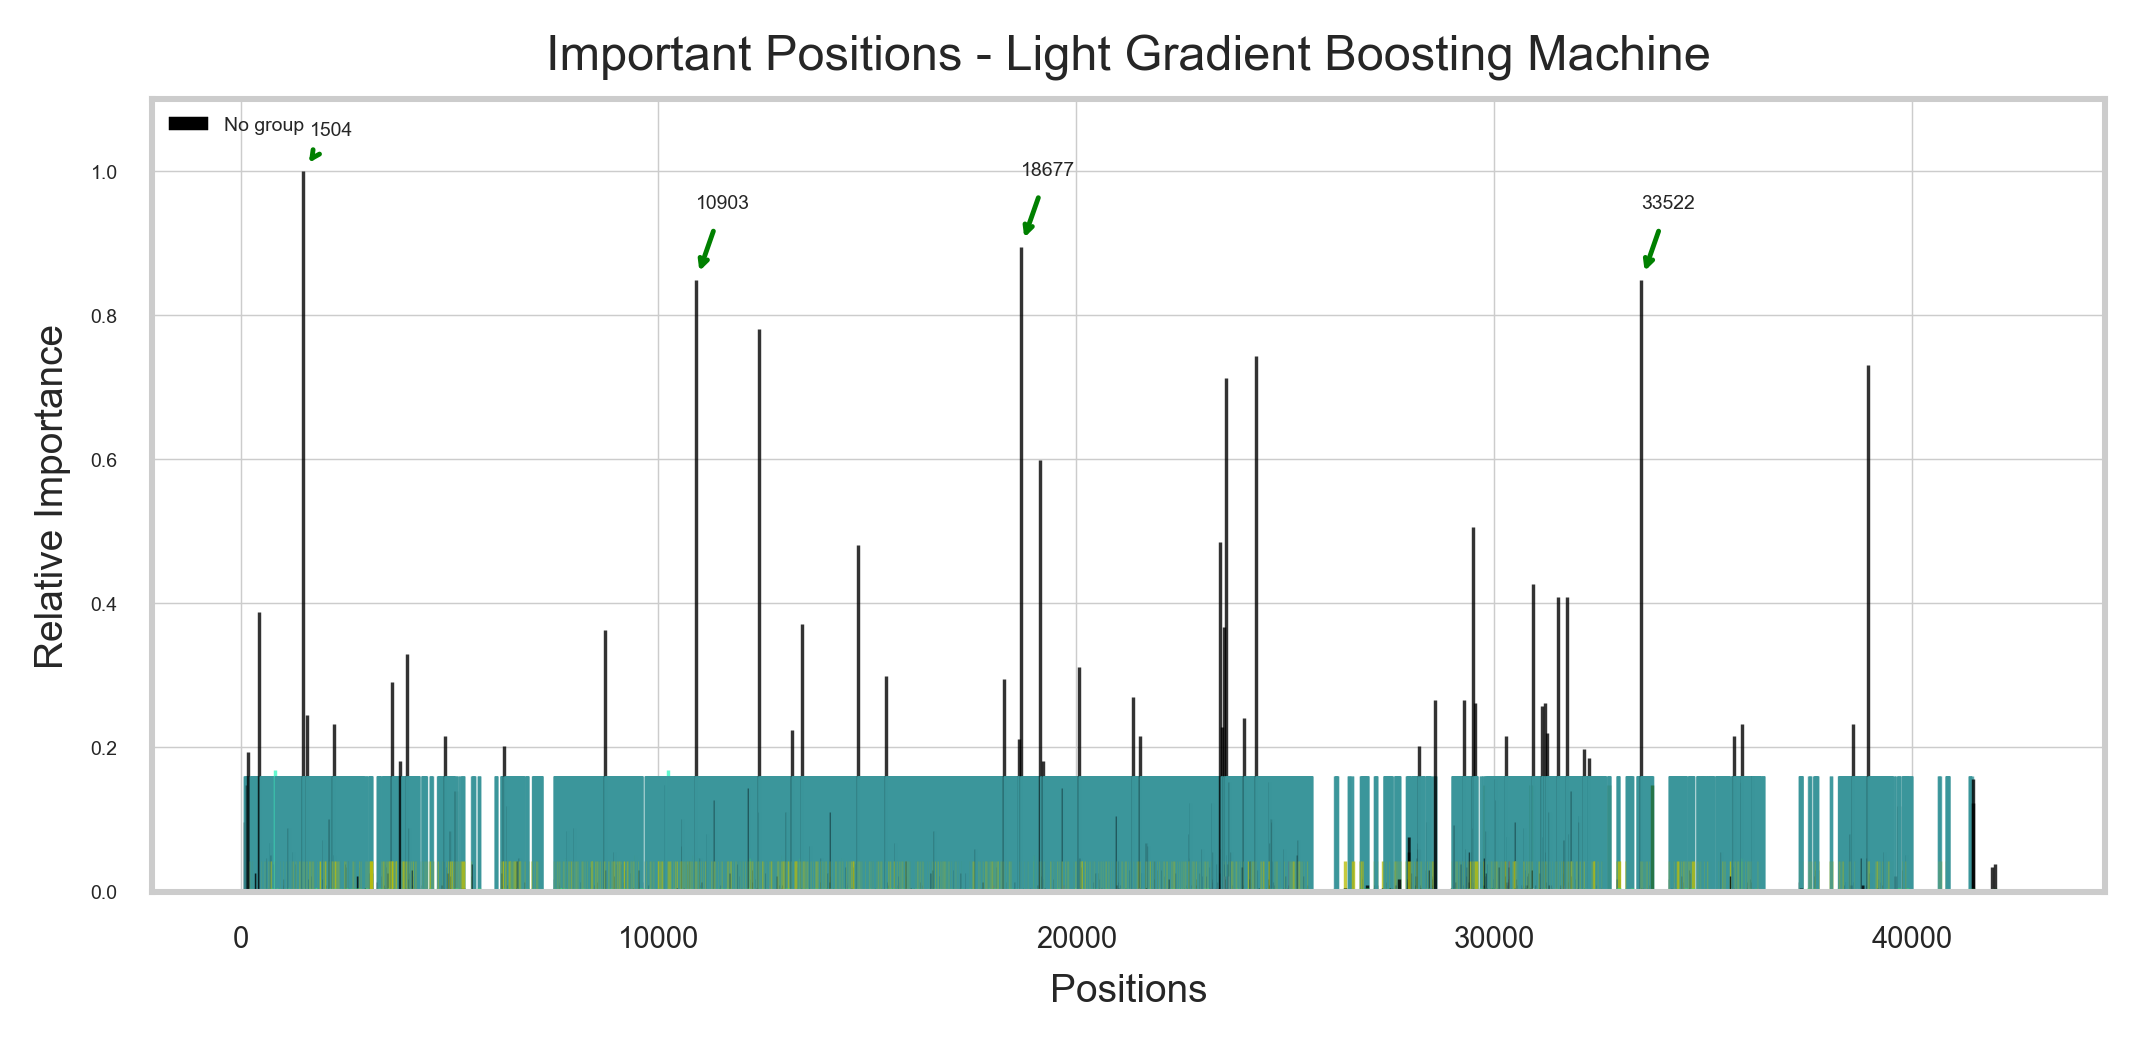

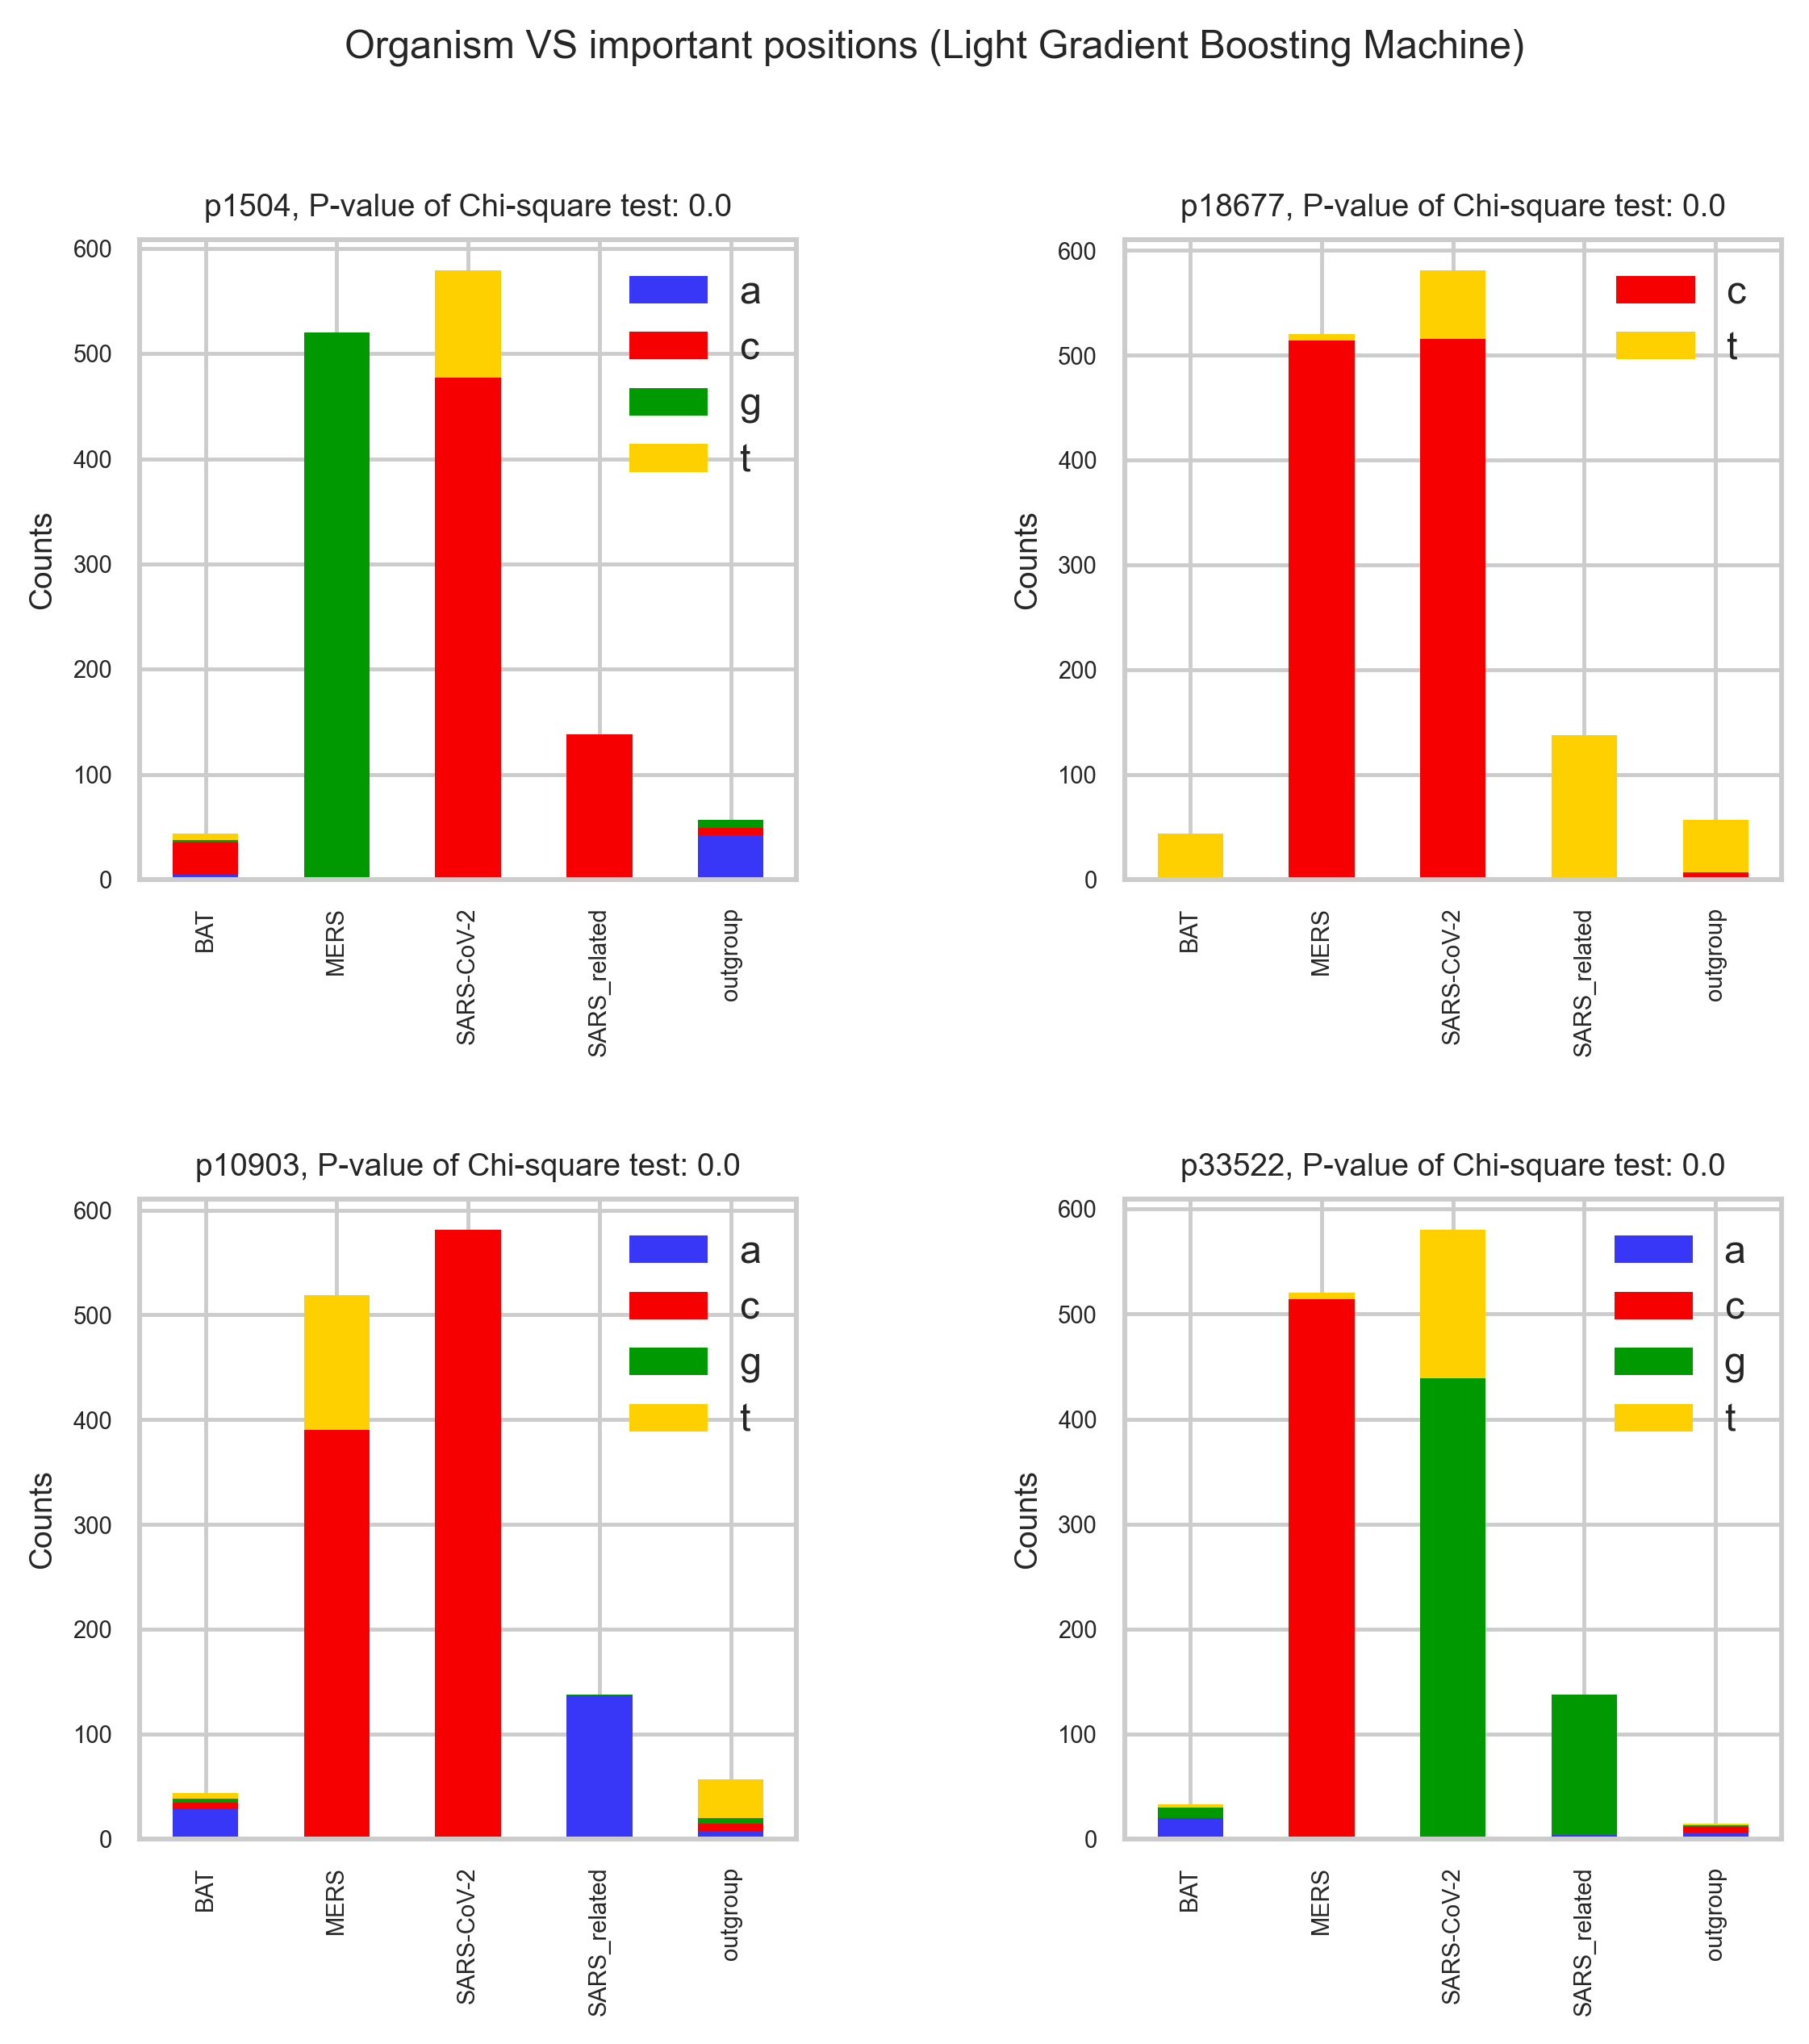

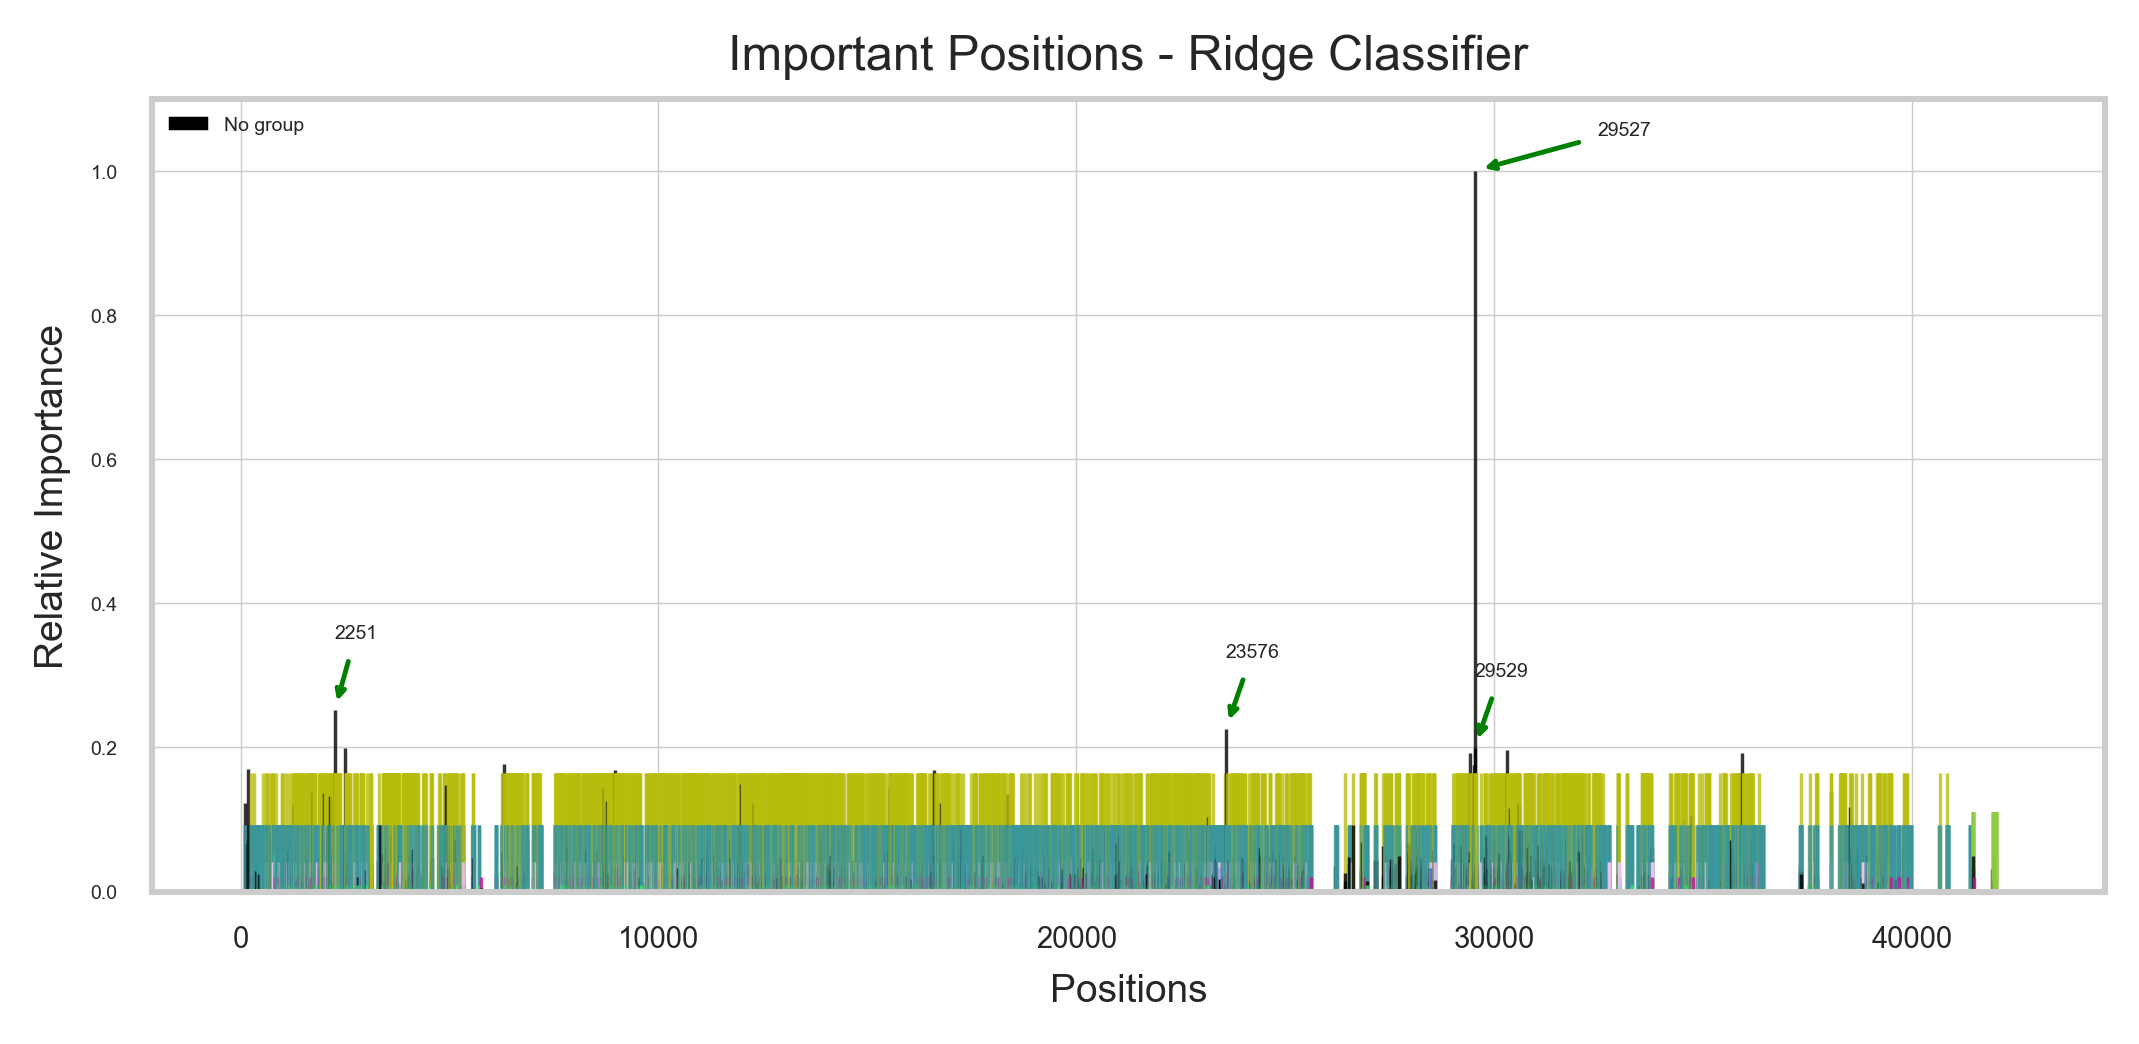

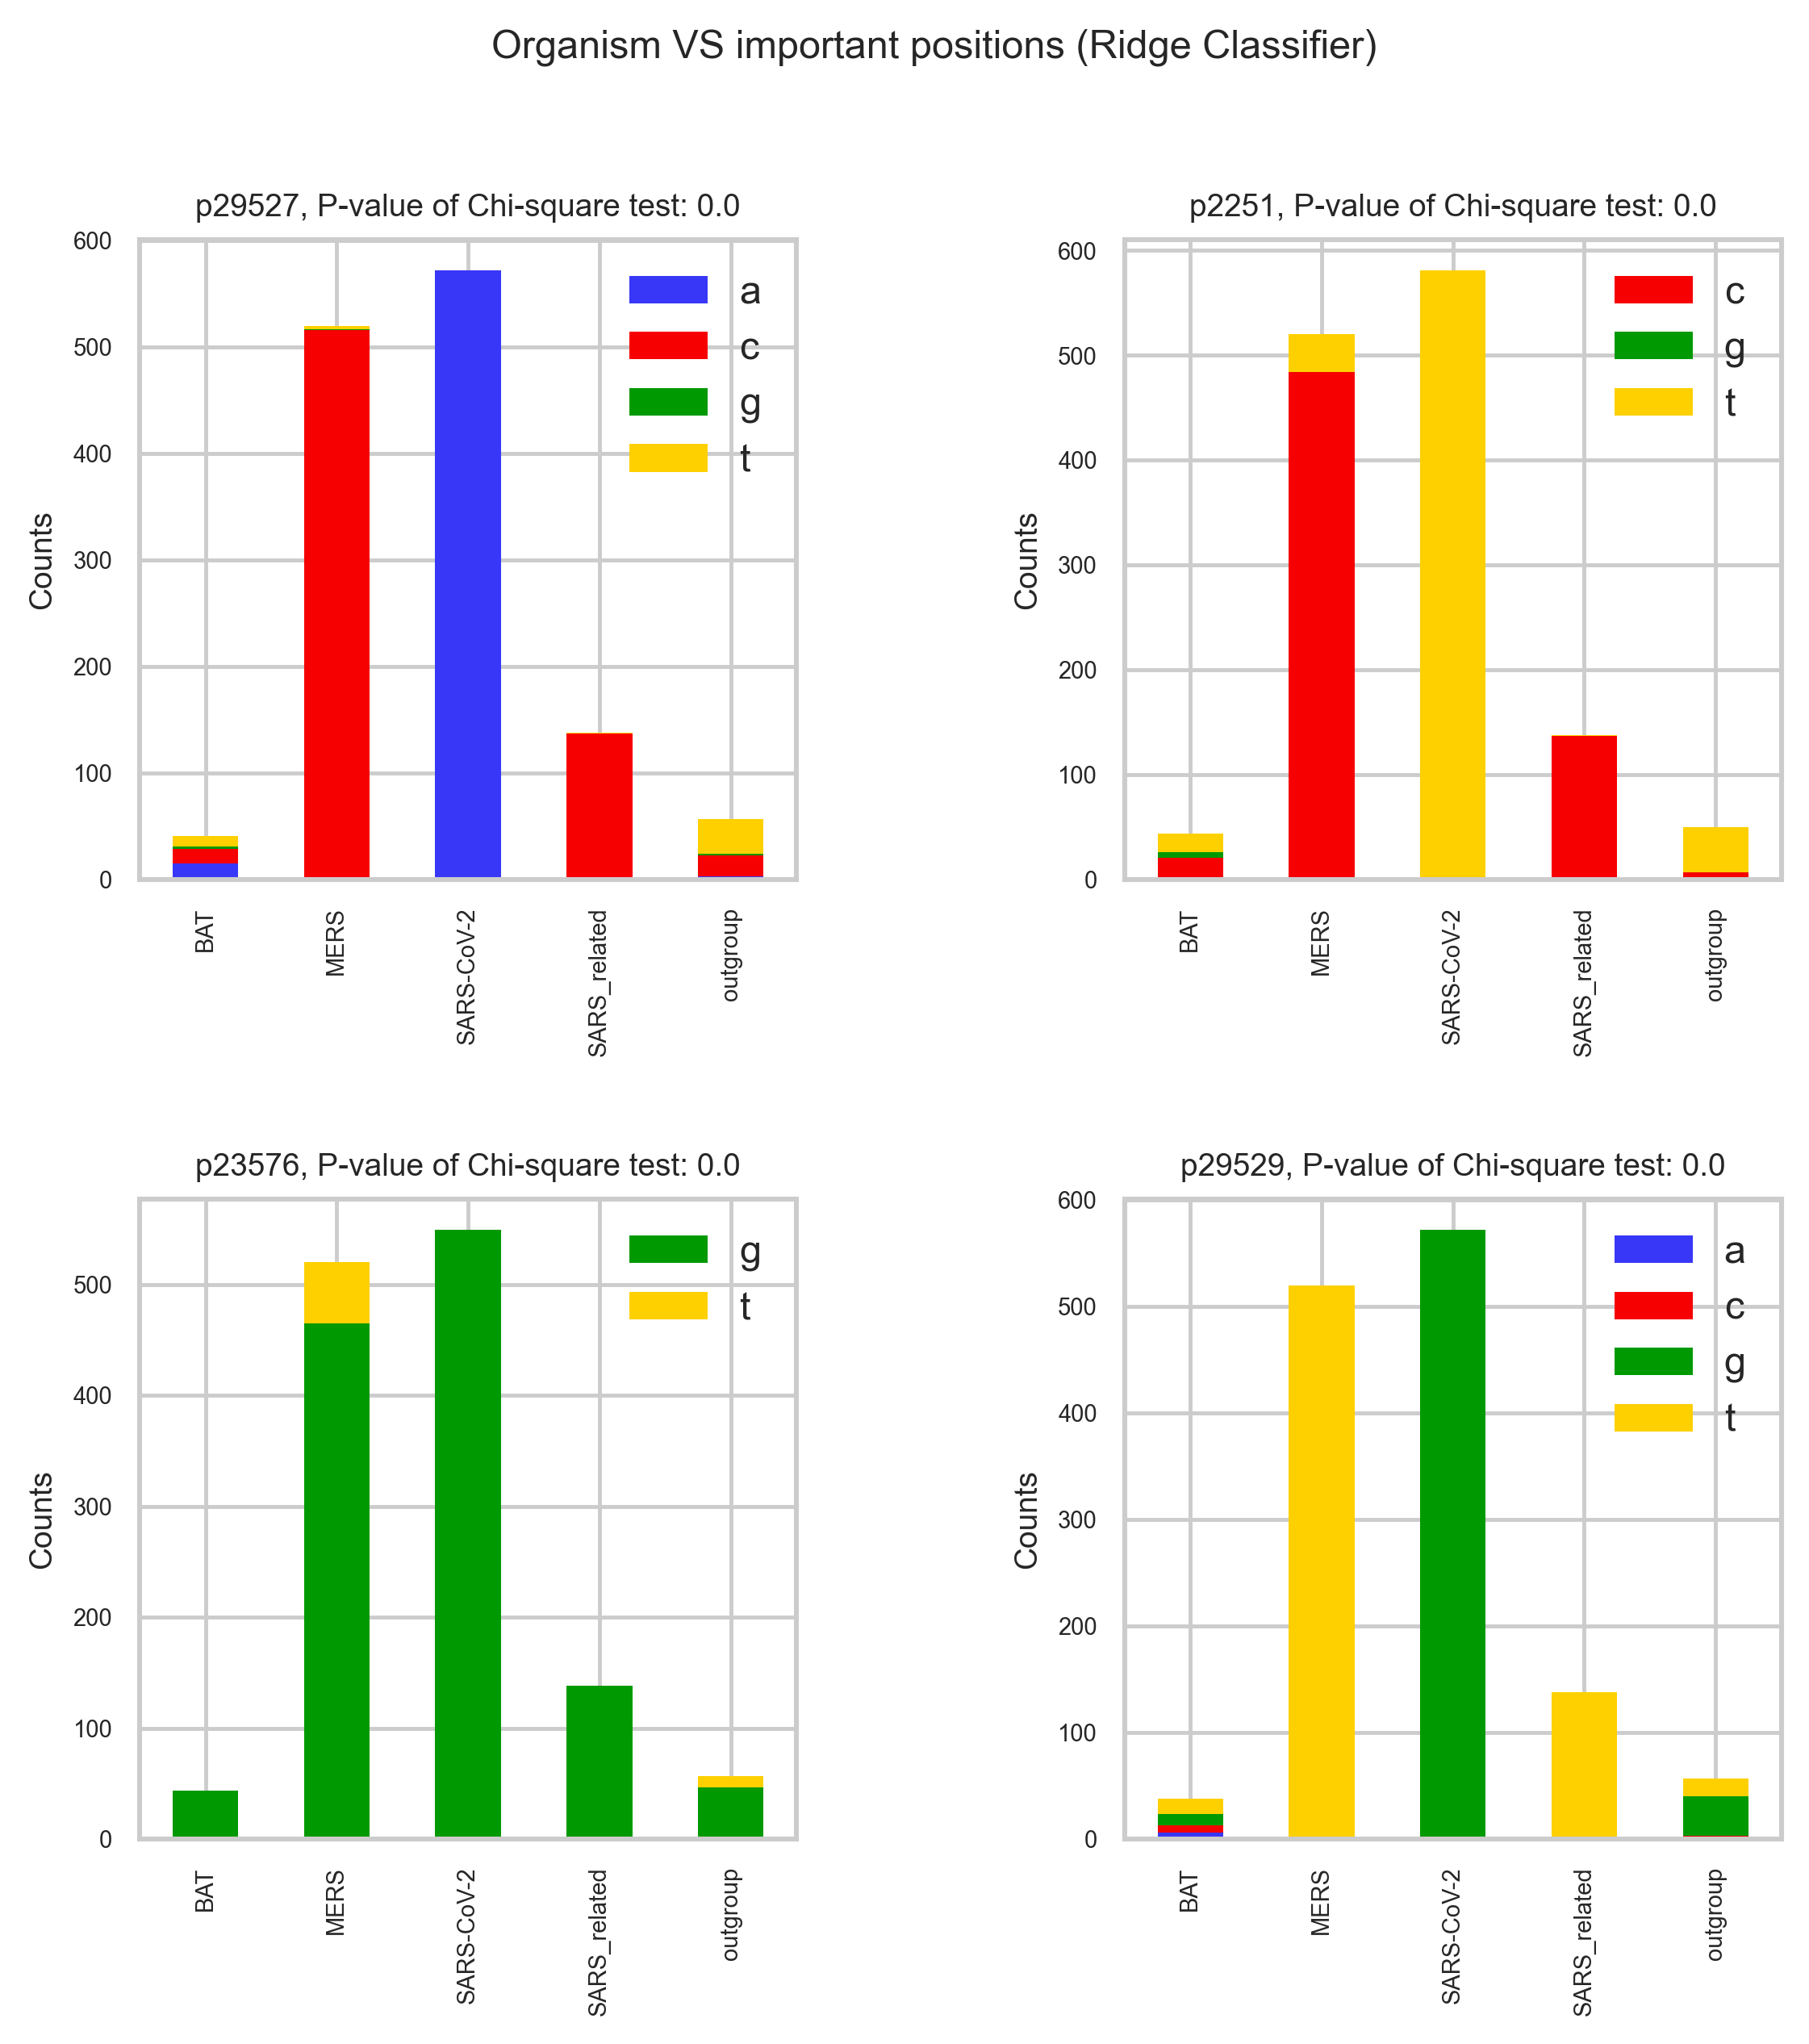

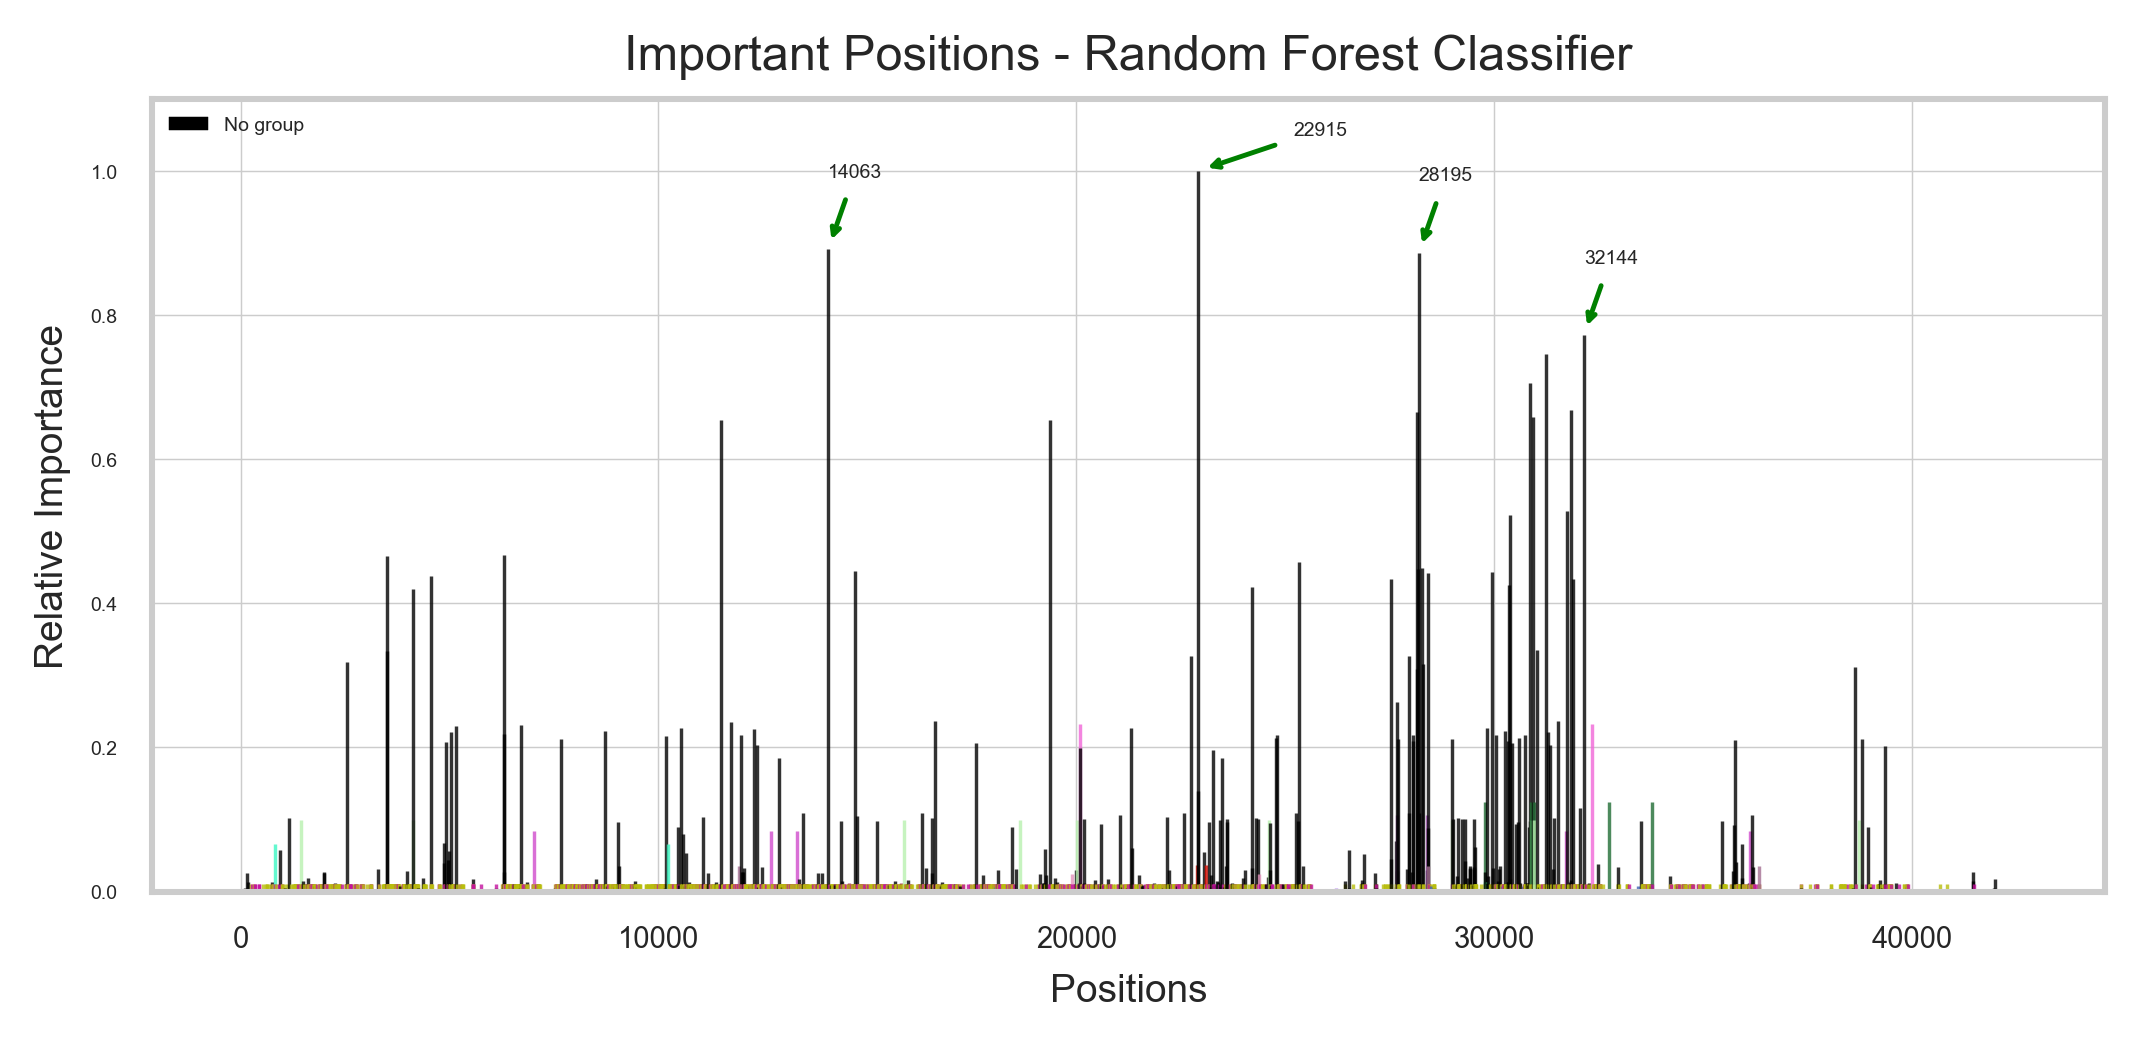

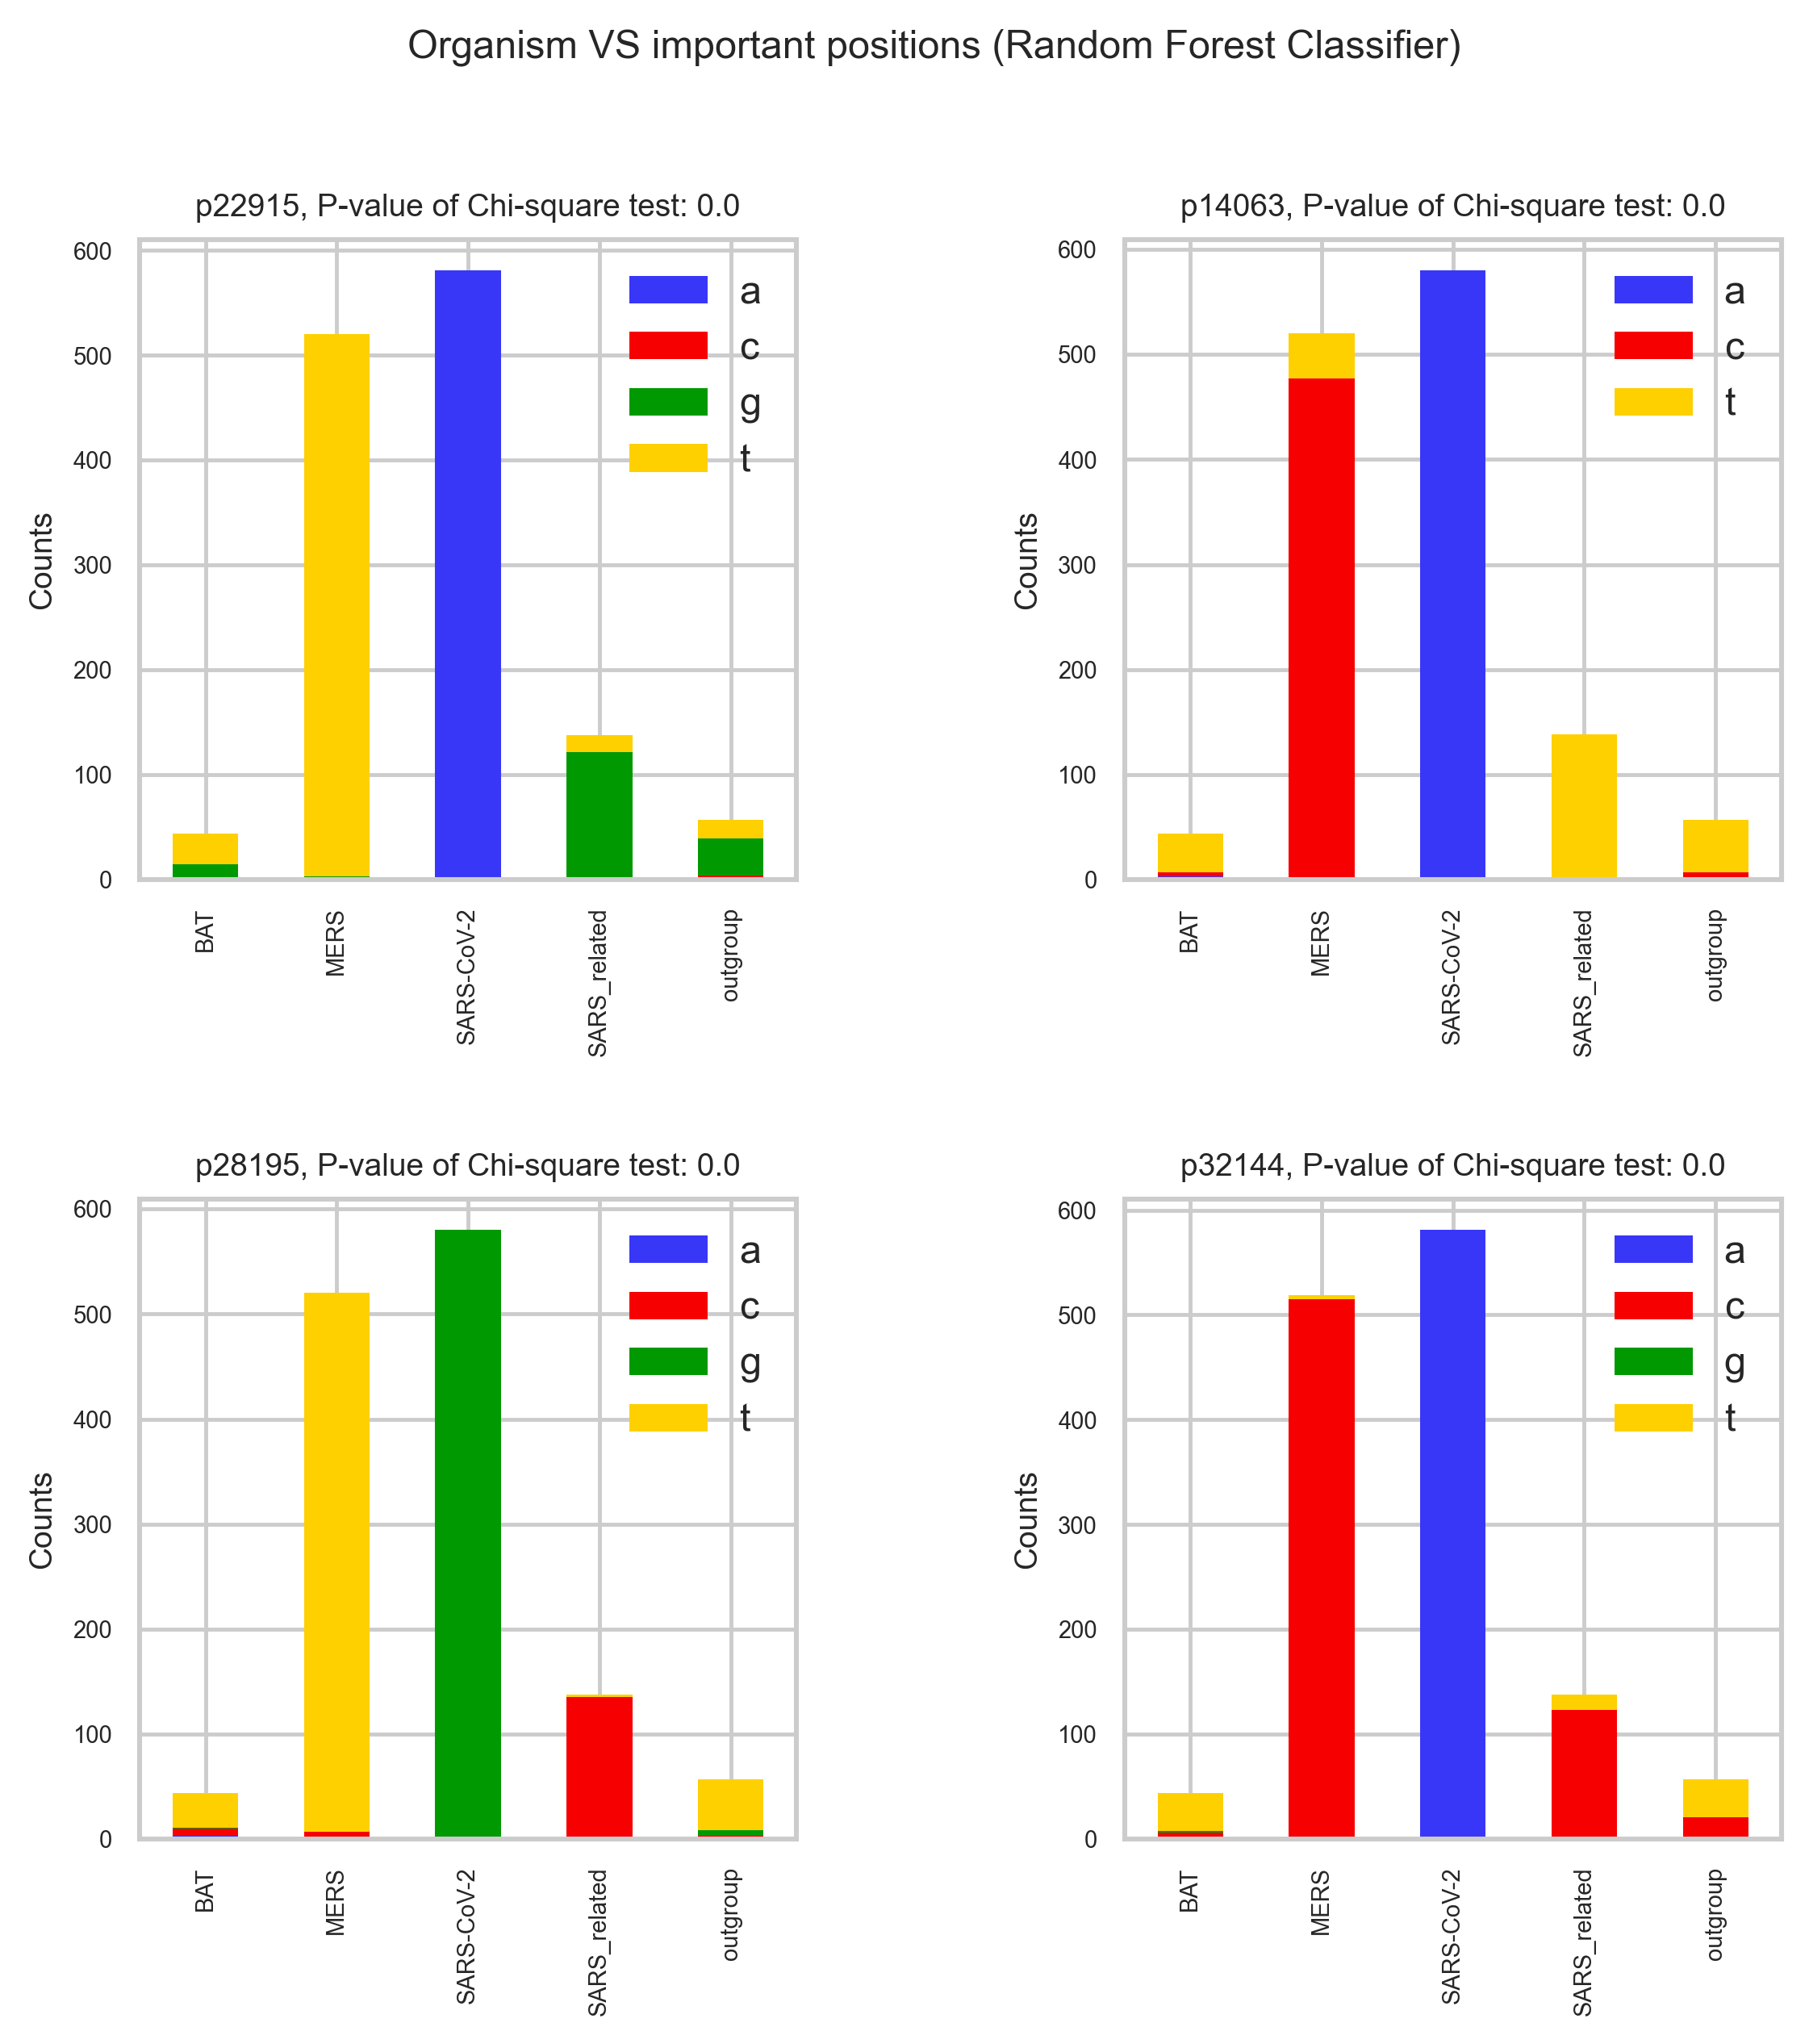

In [17]:
for i in range(3):
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i], 
                  train_cols=train_cols, grouped_features=dc_df,
                  n_positions=df.shape[1],report_dir=report_dir)
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    viz.plot_imp_model(dat =df, trained_model = top_models[i], model_name = model_names[i],
               train_cols= train_cols, grouped_features = dc_df,
                   meta_var = mt, n_positions = df.shape[1], model_type = anaType, report_dir = report_dir)

D:/RahLab/deepBreaks/genome/Genome_Organism_2022-05-09_17-44-43/mean_350.png


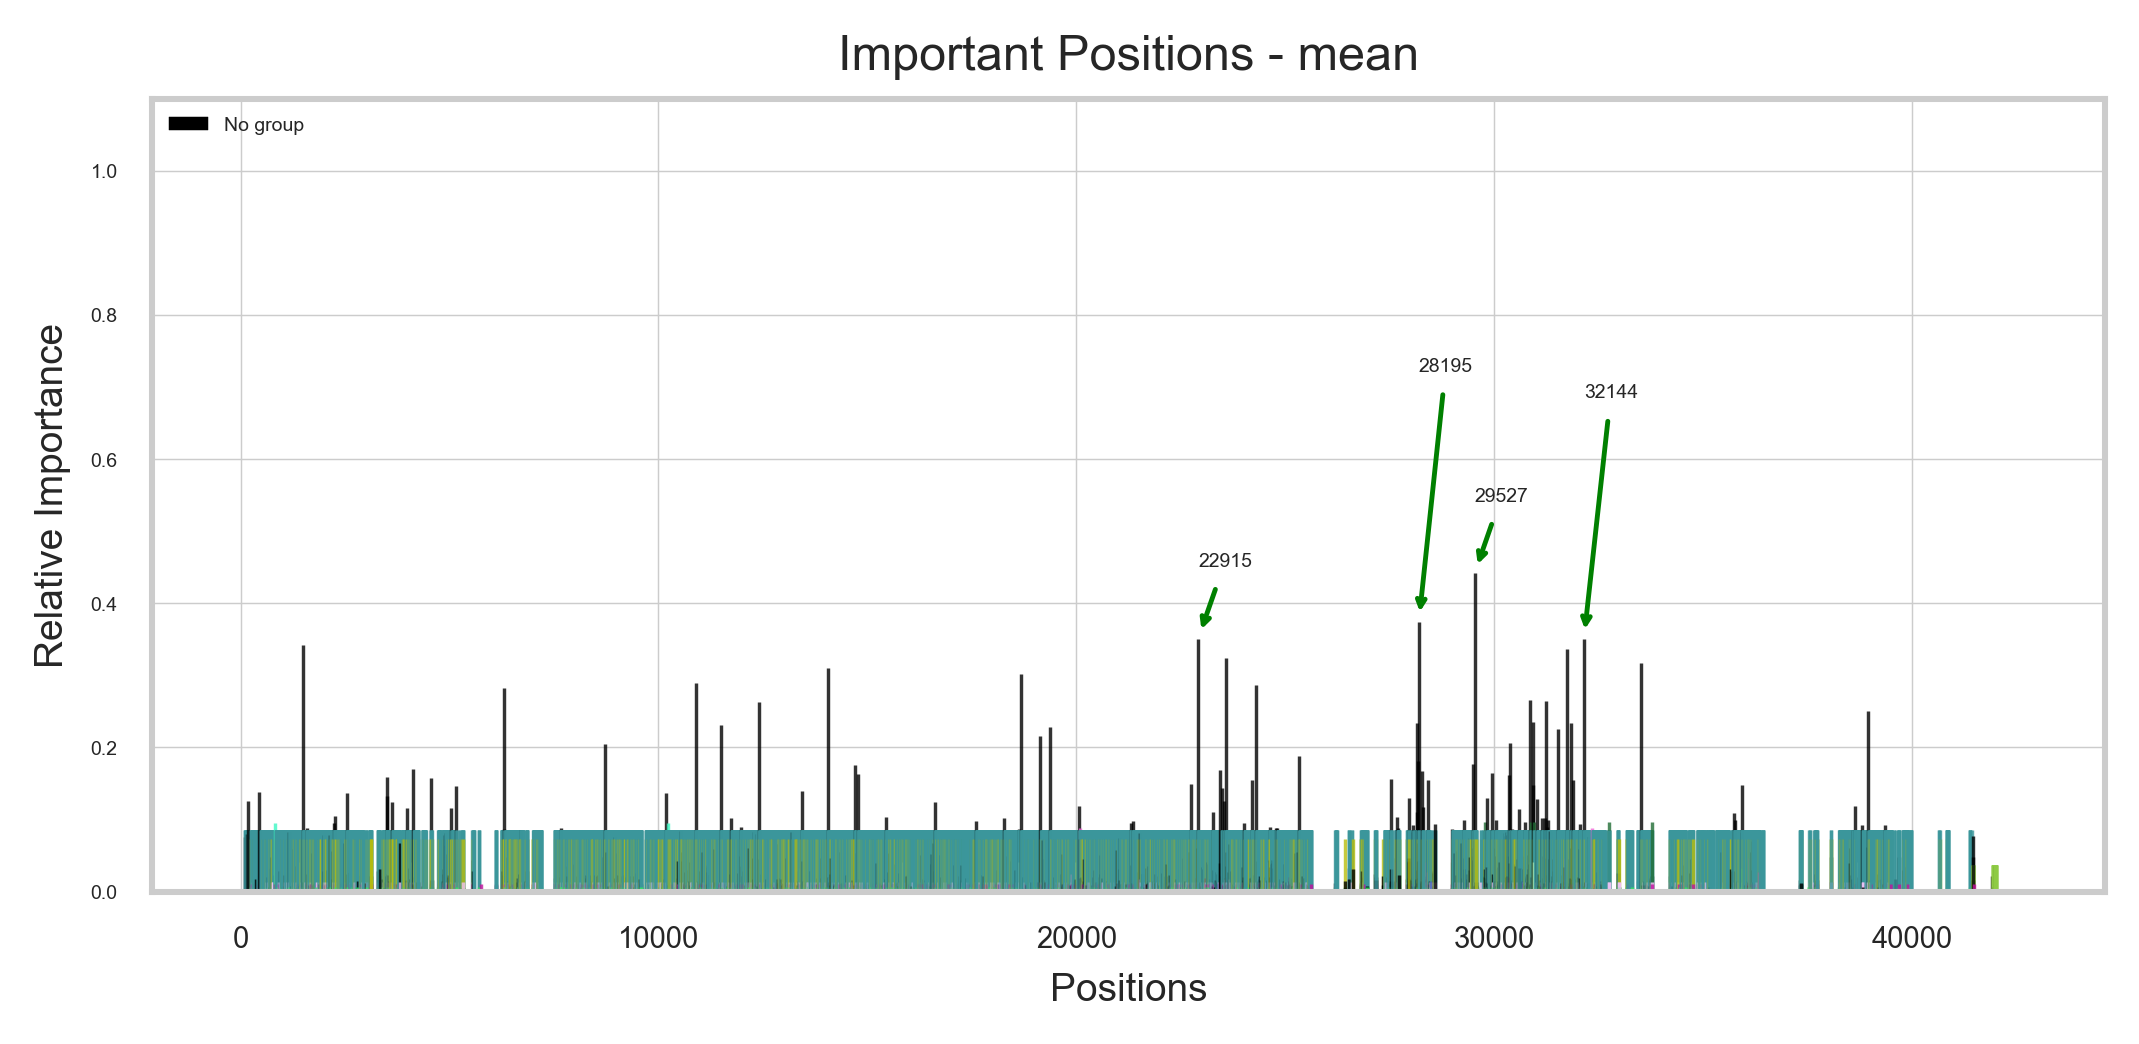

In [18]:
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, train_cols=train_cols,grouped_features=dc_df,
                  n_positions=df.shape[1],report_dir=report_dir)
viz.dp_plot(dat = mean_imp, model_name= 'mean',imp_col='mean_imp', report_dir=report_dir)

In [ ]:
viz.plot_imp_all(trained_models=top_models, dat=df_cleaned, train_cols=train_cols,
             grouped_features=dc_df, meta_var = mt, model_type = anaType,
             n_positions= df.shape[1], report_dir = report_dir)